<span style="font-family:Papyrus; font-size:3em;">Homework 2</span>

<span style="font-family:Papyrus; font-size:2em;">Cross Validation</span>

# Problem

In this homework, you will use cross validation to analyze the effect on the quality of the model fit and parameter estimates
as a result of the number of parameters and the noise in the observational data.

You will investigate models of linear pathways with 2, 4, 6, 8, 10 parameters.
For example, a two parameter model is use $S_1 \xrightarrow{v_1} S_2 \xrightarrow{v_3} S_3$,
where $v_i = k_i s_i$, $k_i$ is a parameter to estimate, and $s_i$ is the concentration of $S_i$.
The initial concentration of $S_1 = 10$, and the true value of $k_i$ is $i$.

You will generate the synthetic data using noise standard deviations of 0.2, 0.5, 0.8, 1.0, and 1.5.

You will design experiments, implement codes to run them, run the experiments, and interpret the results.
You will produce *two* tables structured as the one below. One table will be populated
with $R^2$ values averaged across the folds.
The other table will be populated with the average of the standard deviations of the parameter estimates
across folds for all parameters in the model. 

 |   | 2 | 4 | 6 | 8 | 10
  | -- | -- | -- | -- | -- | -- |
 0.2 | ? | ? | ? | ? | ?
 0.5 | ? | ? | ? | ? | ?
 0.8 | ? | ? | ? | ? | ?
 1.0 | ? | ? | ? | ? | ?
 1.5 | ? | ? | ? | ? | ?
 

1. Write the 3 models in Antimony, and produce plots for their true values. Use a simulation time
of 10 and 100 points.
1. Write a function that creates synthetic data given the parameters std and numParameter.
1. Extend the ``CrossValidator`` class in ``common/util_crossvalidation.py`` by adding the method
``calcAvgParameterStd``. You will do this by creating a new class, ``ExtendedCrossValidator`` that
subclasses ``CrossValidator`` and has the method ``calcAvgParameterStd``. Be sure to include
a test for the new method. **DO NOT COPY CODES FROM COMMON.**
1. Run experiments that produce the tables described above.
1. Using the baseline standard deviation of noise of 0.8, number of parameters of 6, calculate $\mu$, $\alpha_{i,k_i}$,
$\gamma_{i,i_k,j,k_j}$.
1. Answer the following questions
   1. Are there any significant interaction effects?
   1. What is the general effect on $R^2$ and average parameter std as the number of parameters increases?
   1. What does the noise standard deviation influence quality, especially as the number of parameters increases?

# Programming Preliminaries
This section provides the setup to run your python codes.

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIR = "/home/ubuntu/advancing-biomedical-models/common"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIR = "/content/drive/My Drive/Winter 2021/common"
import sys
sys.path.insert(0, CODE_DIR)

In [2]:
import util_crossvalidation as ucv
from SBstoat.namedTimeseries import NamedTimeseries, TIME

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

In [35]:
END_TIME = 5
NUM_POINT = 100
NOISE_STD = 0.5
# Column names
C_NOISE_STD = "noisestd"
C_NUM_PARAMETER = "no. parameters"
C_VALUE = "value"
#
NOISE_STDS = [0.2, 0.5, 0.8, 1.0, 1.5]
NUM_PARAMETERS = [2, 4, 6, 8, 10]

In [19]:
def isSame(collection1, collection2):
    """
    Determines if two collections have the same elements.
    """
    diff = set(collection1).symmetric_difference(collection2)
    return len(diff) == 0
    
# Tests
assert(isSame(range(3), [0, 1, 2]))
assert(not isSame(range(4), range(3)))

# Generate Models

In [4]:
MODEL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
k1 = 1
k2 = 2
"""
rr = te.loada(MODEL)

In [5]:
class LinearModel(object):
    
    def __init__(self, numParameter, s1Value=10):
        """
        numParameter: int
            number of parameters in the model
        s1Value: float
            Initial value for S1
        """
        self.numParameter = numParameter
        self.s1Value = s1Value
        #
        # modelStr - Antimony model
        # parameterDct - true values of parameters
        self.modelStr, self.parameterDct = self._generateModel()
        self.parameterNames = list(self.parameterDct.keys())
        # Calculated by other methods
        self.resultTS = None  # Simulation result
        
    def _generateModel(self):
        """
        Constructs an antimony model.
        
        Returns
        -------
        str: antimony model
        list-str: model parameters
        dict:
            key: parameterName
            value: true value
        """
        def mkSpeciesInitialization(idx, value=0):
            return "\nS%d = %2.2f" % (idx, value)
        #
        reactionStr = ""
        initializationStr = ""
        parameterDct = {}
        for idx in range(1, self.numParameter+1):
            if idx == 1:
                value = self.s1Value
            else:
                value = 0
            parameterName = "k%d" % idx
            parameterDct[parameterName] = idx
            initializationStr += mkSpeciesInitialization(idx, value)
            if idx == self.numParameter:
                    initializationStr += mkSpeciesInitialization(idx + 1, 0)
            initializationStr += "\n%s = %2.2f" % (parameterName, 1.0*idx)
            reactionStr += "\nS%d -> S%d; k%d*S%d" % (idx, idx+1, idx, idx)
        modelStr = "%s\n%s" % (reactionStr, initializationStr)
        return modelStr, parameterDct
    
    def simulate(self, endTime=END_TIME, numPoint=NUM_POINT):
        """
        Simulates the model.
        
        Parameters
        ----------
        endTime: float
            end of the simulation
        numPoint: int
            number of points in the simulation
        """
        rr = te.loada(self.modelStr)
        arr = rr.simulate(0, endTime, numPoint)
        self.resultTS = NamedTimeseries(namedArray=arr)
    
    def plotTrueModel(self, **kwargs):
        """
        Plots the result of a simulation.
        
        Parameters
        ----------
        kwargs: dict
            arguments passed to plot
            
        Returns
        -------
        Matplotlib.Axes
        """
        if self.resultTS is None:
            self.simulate()
        return ucv.plotTS(self.resultTS, linetype="line", **kwargs)

# Tests
numParameter = 3
model = LinearModel(numParameter)
_ = te.loada(model.modelStr)
assert(len(model.parameterDct) == numParameter)
# All species and constants are present
for term in ["S", "k"]:
    trues = ["%s%d" % (term, n) in model.modelStr for n in range(1, numParameter+1)]            
    assert(all(trues))
#   simulate
model.simulate()
assert(len(model.resultTS) > 0)
#   plotResult
model.plotTrueModel(title="test", isPlot=False)

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

# Generate Synthetic Data

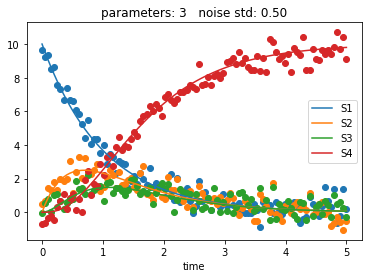

In [6]:
class ExtendedLinearModel(LinearModel):
    """Extends Model by providing generated observations."""
    
    def __init__(self, *args, **kwargs):
        """
        numParameter: int
            number of parameters in the model
        """
        super().__init__(*args, **kwargs)
        self.noiseStd = None
        self.observedTS = None
    
    def generateObserved(self, noiseStd=NOISE_STD, **kwargs):
        """
        Creates synthetic data for the model.

        model: Model
        noiseStd: float
        kwargs: dict
            optional keywords passed to run model
        """
        self.noiseStd = noiseStd
        self.simulate(**kwargs)
        self.observedTS = ucv.makeSyntheticData(fittedTS=self.resultTS, std=noiseStd)
        
    def plotTrueAndGeneratedData(self, isPlot=True):
        ax = self.plotTrueModel(isPlot=isPlot)
        if self.observedTS is None:
            self.generateObserved()
        title = "parameters: %d   noise std: %2.2f" % (self.numParameter, self.noiseStd)
        ucv.plotTS(self.observedTS, title=title, isPlot=isPlot, ax=ax)

# Tests
model = ExtendedLinearModel(3)
model.generateObserved()
assert(len(model.observedTS) == len(model.observedTS))
#  plotTrueAndGeneratedData
model.plotTrueAndGeneratedData()

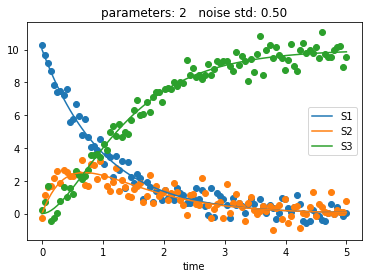

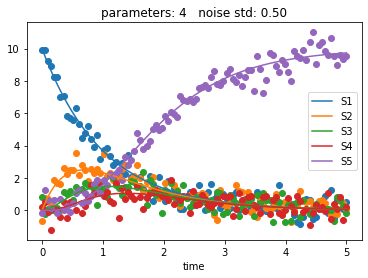

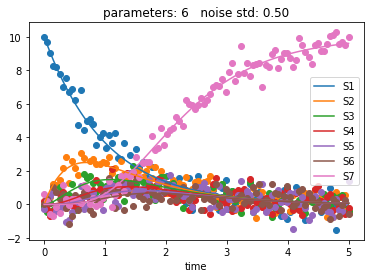

In [7]:
# Here are some examples of the data
for numParameter in [2, 4, 6]:
    model = ExtendedLinearModel(numParameter)
    model.plotTrueAndGeneratedData()

# ``ExtendedCrossValidator``

In [8]:
class ExtendedCrossValidator(ucv.CrossValidator):
    """Calculates the average standard deviation of parameter estimates."""
    
    def calcAverageParameterStd(self):
        stdDct = {n: [] for n in self.parameterNames}
        for parameters in self.parametersCol:
            valuesDct = parameters.valuesdict()
            [stdDct[n].append(valuesDct[n]) for n in self.parameterNames]
        # Stds of the parameters
        stds = [np.std(stdDct[n]) for n in self.parameterNames]
        return np.mean(stds)
    
# Tests
numFold = 5
numParameter = 4
model = ExtendedLinearModel(numParameter)
model.generateObserved(noiseStd=1.5)
validator = ExtendedCrossValidator(numFold, model.modelStr, model.observedTS, model.parameterNames,
    trueParameterDct=model.parameterDct, method="least_squares",
    lower=0, upper=100)
validator.execute()
assert(validator.calcAverageParameterStd() < 0.5)

# Conduct experiments and tabulate results

In [22]:
def runExperiments(numParameters, noiseStds, numFold=5, **kwargs):
    """
    Constructs tables for the results of computational experiments.
    Experiments are described by the collection of values for the
    number of parameters in the model and the standard deviation of noise.
    
    Parameters
    ----------
    numParameters: list-int
    noiseStds: list-float
    numFold: int
    kwargs: dict
        optional arguments for ExtendedCrossValidator
    
    Returns
    -------
    pd.DataFrame: parameterStdDF - average std of parameter estimates within a fold
        columns: NUM_PARAMETER in model
        index: NOISE_STD of observational data
        values: average standard deviation of parameter estimates
    pd.DataFrame: rsqDF - average R2 for folds
        columns: NUM_PARAMETER in model
        index: NOISE_STD of observational data
        values: average R2
    """
    def mkTable(dct):
        """
        Creates a dataframe table from a dictionary.
        Columns are the number of parameters.
        Rows are the standard deviation of the noise.
        """
        df = pd.DataFrame(dct)
        df = df.set_index(C_NOISE_STD)
        tableDF = df.pivot_table(values=C_VALUE,columns=C_NUM_PARAMETER,
                                 index=C_NOISE_STD)
        return tableDF
    def updateDct(dct, noiseStd, numParameter, value):
        """
        Update entries in the dictionary.
        """
        dct[C_NOISE_STD].append(noiseStd)
        dct[C_NUM_PARAMETER].append(numParameter)
        dct[C_VALUE].append(value)
    #
    parameterDct = {C_NOISE_STD: [], C_NUM_PARAMETER: [], C_VALUE: []}
    rsqDct = parameterdct = {C_NOISE_STD: [], C_NUM_PARAMETER: [], C_VALUE: []}
    for noiseStd in noiseStds:
        for numParameter in numParameters:
            model = ExtendedLinearModel(numParameter)
            model.generateObserved(noiseStd=noiseStd)
            validator = ExtendedCrossValidator(numFold, model.modelStr, model.observedTS, 
                model.parameterNames,
                trueParameterDct=model.parameterDct, **kwargs)
            validator.execute()
            updateDct(parameterDct, noiseStd, numParameter,
                     validator.calcAverageParameterStd())
            updateDct(rsqDct, noiseStd, numParameter,
                      np.mean(validator.rsqs))
    parameterStdDF = mkTable(parameterDct)
    rsqDF = mkTable(rsqDct)
    return parameterStdDF, rsqDF

# Tests
numParameters = [2, 4, 10]
noiseStds = [0.5, 0.8, 1.5]
parameterStdDF, rsqDF = runExperiments(numParameters, noiseStds)
for df in [parameterStdDF, rsqDF]:
    assert(isSame(numParameters, df.columns))
    assert(isSame(noiseStds, df.index))

# Calculate the effects
Here, we calculate $\mu$, $\alpha_{i, k_i}$, and $\gamma_{i, k_i, j, k_j}$.

In [46]:
def calculateEffects(tableDF):
    """
    """
    columns = tableDF.columns.tolist()
    rows = tableDF.index.tolist()
    numRow = len(rows)
    numCol = len(columns)
    #
    if numRow % 2 != 1:
        raise ValueError("Must have an odd number of rows.")
    if numCol % 2 != 1:
        raise ValueError("Must have an odd number of columns.")
    centerRow = numRow // 2 
    centerCol = numCol // 2 
    #
    mu = tableDF.loc[rows[centerRow], columns[centerCol]]
    #
    rowAlphaSer = tableDF.loc[rows, columns[centerCol]] - mu
    columnAlphaSer = tableDF.loc[rows[centerRow], columns] - mu
    # Calculate the values for each entry
    gammaDF = tableDF.copy()
    for column in columns:
        for row in rows:
            gammaDF.loc[row, column] = gammaDF.loc[row, column]  \
                  - mu - rowAlphaSer.loc[row] - columnAlphaSer.loc[column]
    #
    return mu, rowAlphaSer, columnAlphaSer, gammaDF
                              
# Tests
numParameters = [2, 4, 6]
noiseStds = [0.5, 0.8, 1.5]
parameterStdDF, rsqDF = runExperiments(numParameters, noiseStds)
mu, rowAlphaSer, columnAlphaSer, gammaDF = calculateEffects(rsqDF)
assert((0 <= mu) and (mu <= 1.0))
assert(len(rowAlphaSer) == len(noiseStds))
assert(len(columnAlphaSer) == len(numParameters))

Calculate Rsqs and then calculate mu, alpha, gamma

In [47]:
# Calculate the raw tables of R2 and parameter standard deviations
parameterStdDF, rsqDF = runExperiments(NUM_PARAMETERS, NOISE_STDS)

## Parameter standard deviations

In [48]:
parameterStdDF

no. parameters,2,4,6,8,10
noisestd,,,,,
0.2,0.006414,0.026300,0.063325,0.092866,0.120872
0.5,0.025868,0.056490,0.109498,0.240055,0.282572
0.8,0.030011,0.128872,0.800097,0.310986,0.305797
1.0,0.028392,0.317195,0.252926,0.309349,0.563710
1.5,0.045649,0.297269,0.661045,0.668578,1.223928


In [54]:
mu, noiseStdAlphaSer, numParameterAlphaSer, gammaDF = calculateEffects(parameterStdDF)

In [52]:
# mu
mu

0.8000969312278908

In [53]:
# Alpha for noise standard deviations
noiseStdAlphaSer

noisestd
0.2   -0.736771
0.5   -0.690599
0.8    0.000000
1.0   -0.547171
1.5   -0.139052
Name: 6, dtype: float64

In [55]:
# Alpha for number of parameters
numParameterAlphaSer

no. parameters
2    -0.770086
4    -0.671225
6     0.000000
8    -0.489111
10   -0.494300
Name: 0.8, dtype: float64

In [59]:
gammaDF

no. parameters,2,4,6,8,10
noisestd,,,,,
0.2,-0.099295,-0.080769,0.0,-0.026324,0.012206
0.5,-0.080979,-0.073942,0.0,-0.037042,-0.013274
0.8,0.000000,0.000000,0.0,0.000000,0.000000
1.0,-0.001624,-0.029081,0.0,-0.057285,-0.075790
1.5,0.057889,0.005317,0.0,-0.060343,-0.156534


## $R^2$

In [56]:
mu, noiseStdAlphaSer, numParameterAlphaSer, gammaDF = calculateEffects(rsqDF)

In [49]:
rsqDF

no. parameters,2,4,6,8,10
noisestd,,,,,
0.2,0.996485,0.994874,0.993029,0.990726,0.988191
0.5,0.980555,0.967456,0.958784,0.945762,0.928465
0.8,0.943858,0.923722,0.841107,0.865128,0.824063
1.0,0.937611,0.890018,0.836485,0.803220,0.743650
1.5,0.841753,0.769045,0.681114,0.644792,0.507536


In [57]:
# Alpha for noise standard deviations
noiseStdAlphaSer

noisestd
0.2    0.151921
0.5    0.117676
0.8    0.000000
1.0   -0.004623
1.5   -0.159993
Name: 6, dtype: float64

In [58]:
# Alpha for number of parameters
numParameterAlphaSer

no. parameters
2     0.102751
4     0.082614
6     0.000000
8     0.024021
10   -0.017044
Name: 0.8, dtype: float64

In [60]:
gammaDF

no. parameters,2,4,6,8,10
noisestd,,,,,
0.2,-0.099295,-0.080769,0.0,-0.026324,0.012206
0.5,-0.080979,-0.073942,0.0,-0.037042,-0.013274
0.8,0.000000,0.000000,0.0,0.000000,0.000000
1.0,-0.001624,-0.029081,0.0,-0.057285,-0.075790
1.5,0.057889,0.005317,0.0,-0.060343,-0.156534
